In [1]:

import os
import gc
import re
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()


np.random.seed(0)
tf.random.set_seed(0)


# Plant Pathology 2020
## Identify the category of diseases in apple trees

## Introduction 

In the agricultural sector, there are different diseases in apple trees as in every plant. 
Various drugs are used to prevent them. However, these diseases are costly to discover and may not be done accurately. 
In other words, definitions made by human hands may not always be correct. 
Therefore, the discovery of these diseases with the help of computers both speeds up the process and reduces wasted costs. 
It is also done with high accuracy. CNN, which is a type of artificial neural network, will be used to make these 
classifications and analyzes. These networks, which work better with images, will provide high accuracy in our project.

## Why this project is useful for society
Most human-made things need to be checked for accuracy. Since there are factors that can affect human life in the agricultural 
sector, it is more correct to make computer-oriented discoveries and classifications rather than human-oriented ones. 
Incorrect drug use can affect both people and trees. Thanks to this project, diseases will be discovered accurately and 
mistakes will be prevented. Thus, the amount of money transferred to the agricultural sector and spent on waste will decrease 
at a high rate, and the waste of fruits will be prevented.

Identification of diseases in humans causes both losses of money and loss of time. This will also be prevented in our computer 
vision-based application. Thus, it will be an application that everyone will benefit from.

## Why team members are interested in this project 
I chose this project topic because it gives me happiness to know and even to see that I can help, benefit or prevent 
any negativity that may affect human life and nature.

## Dataset information
### Dataset explanation 
There are 3 files in the dataset: images, train.csv, and test.csv. The image file contains images of the leaves of apple trees. Train.csv file,

- image_id
- combinations
- healthy
- rust
- scab,

keeps its parameters. Image_id will tell us which images we need to access from the images file. 
Other parameters are categories that show which disease or not the photo whose id is taken has a disease. 
This file will be used for the development of the model we will create. 
Test.csv contains only image_id. These ids will also be used to access the images from the images file. 
Also, this file will be used to see how much accuracy our model gives in different datasets.


- Apple rust (pas) causes bright yellowish-orange spots and red or yellow streaks, usually on the outer edges of leaves.

- Apple scab (kabarma) causes greenish-black leaf spots. It may cause deformations. Multiple-disease has both of them (scub, rust).

### Easy to classify/solve examples (for humans) from dataset

It is easy for him to choose the ones with very obvious diseases among the pictures at hand. 
However, it can be difficult to choose among similar leaves.

### Hard to classify/solve examples (for humans) from dataset 

Even if there is not more than one disease on the leaves, sometimes people cannot classify correctly and can tell any disease. 
This can also cause problems. In our model, such a thing will not happen. However, there are different problems for models 
as well. One of them is that the data set is not correct. That is, some pictures are exactly the same. This causes data 
duplication. There are also mislabeled images. Finding solutions to these is a bit difficult. Manual correction is more logical,
but this causes a waste of time. To prevent this, it would be more useful to do data augmentation. It allows reducing the rate 
of errors caused by these.



In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


**LOAD IMAGES**

In [3]:

from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input, GlobalMaxPool2D

import matplotlib.pyplot as plt

import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

In [4]:
#define parameters
batch_size = 32
img_height = 180
img_width = 180

Since the our dataset images are 180x180x3 pixels, we define img_width and img_height to be 180. We use a batch size of 32 samples, which means that 32 samples are fed forward every time before a model improvement is calculated. We'll do 20 epochs, or passing all data 20 times (in batches of 32 samples, many batches per epoch), and have 4 classes: multipledisease,healty,scab,rust. We also use 20% of the training data, or 0.2, for validation during optimization. Finally, we wish to see as much output as possible, thus configure the training process to be verbose.

In [5]:
df = pd.read_csv("train.csv", index_col=0)
print(df.shape)
df.head()

(1821, 4)


healthy  multiple_diseases  rust  scab
image_id                                        
Train_0         0                  0     0     1
Train_1         0                  1     0     0
Train_2         1                  0     0     0
Train_3         0                  0     1     0
Train_4         1                  0     0     0

In [6]:
import shutil
from shutil import copyfile

if os.path.exists('temp'):
    shutil.rmtree('temp')

os.mkdir('temp')
os.mkdir('temp/images')
os.mkdir('temp/images/healthy')
os.mkdir('temp/images/multiple_diseases')
os.mkdir('temp/images/rust')
os.mkdir('temp/images/scab')

In [7]:
SOURCE = 'C:\\Users\\VOLKAN MAZLUM\\Desktop\\image'

SPLIT_DIR = 'temp/images/'

# copy images to train directory
for index, data in df.iterrows():
    label = df.columns[np.argmax(data)]
    filepath = os.path.join(SOURCE, index + ".jpg")
    destination = os.path.join(SPLIT_DIR, label, index + ".jpg")
    copyfile(filepath, destination)
    

In [8]:
#create training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1821 files belonging to 4 classes.
Using 1457 files for training.


In [9]:
#create validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    'temp/images',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 1821 files belonging to 4 classes.
Using 364 files for validation.


In [10]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure([go.Pie(labels=df.columns[0:],
           values=df.iloc[:, 0:].sum().values)])

fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.show()

In [11]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(num_classes, class_names)

4 ['healthy', 'multiple_diseases', 'rust', 'scab']


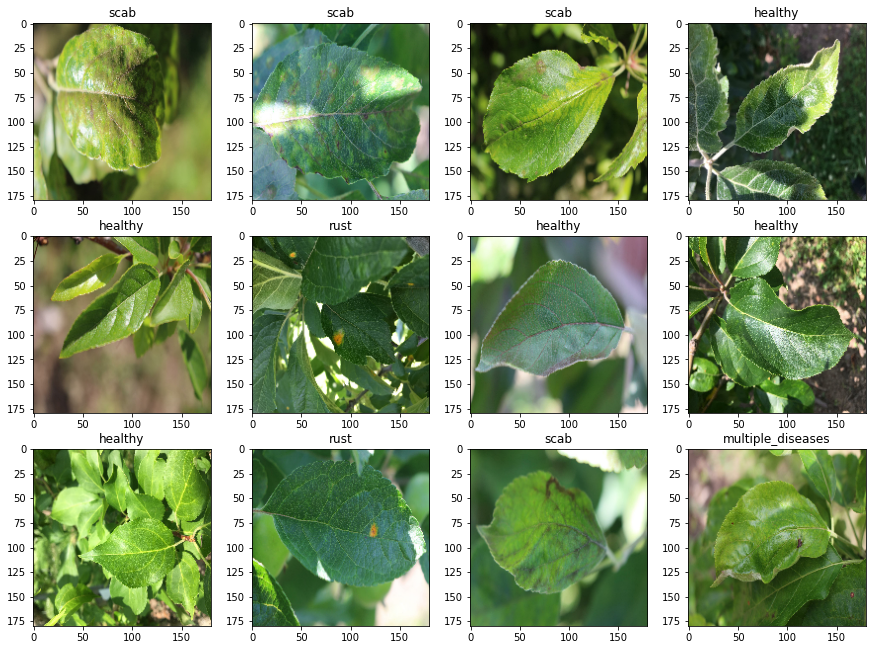

In [15]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4,4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[list(labels[i]).index(1)])
       

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Image processing and augmentation**

***Flipping ***

Flipping is a simple transformation that involves index-switching on the image channels. In vertical flipping, the order of rows is exchanged, whereas in vertical flipping, the order of rows is exchanged. 

***Convolution ***

Convolution is a rather simple algorithm which involves a kernel (a 2D matrix) which moves over the entire image, calculating dot products with each window along the way. The GIF below demonstrates convolution in action.

***BatchNormalization layer***

Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

***MaxPool***

Max pooling is very similar to convolution, except it involves finding the maximum value in a window instead of finding the dot product of the window with a kernel. Max pooling does not require a kernel and it is very useful in reducing the dimensionality of convolutional feature maps in CNNs. The image below demonstrates the working of MaxPool

***Global Average Pooling***

Use global average pooling blocks as an alternative to the Flattening block after the last pooling block of your convolutional neural network. Using 2D Global average pooling block can replace the fully connected blocks of your CNN.



In [163]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="maxpool.png", width=1000, height=750)

In [162]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="convol.gif", width=1000, height=750)



In [164]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="globalaveragepooling.png", width=800, height=750)



In [13]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential(
  [
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0),
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3))
  ]
)



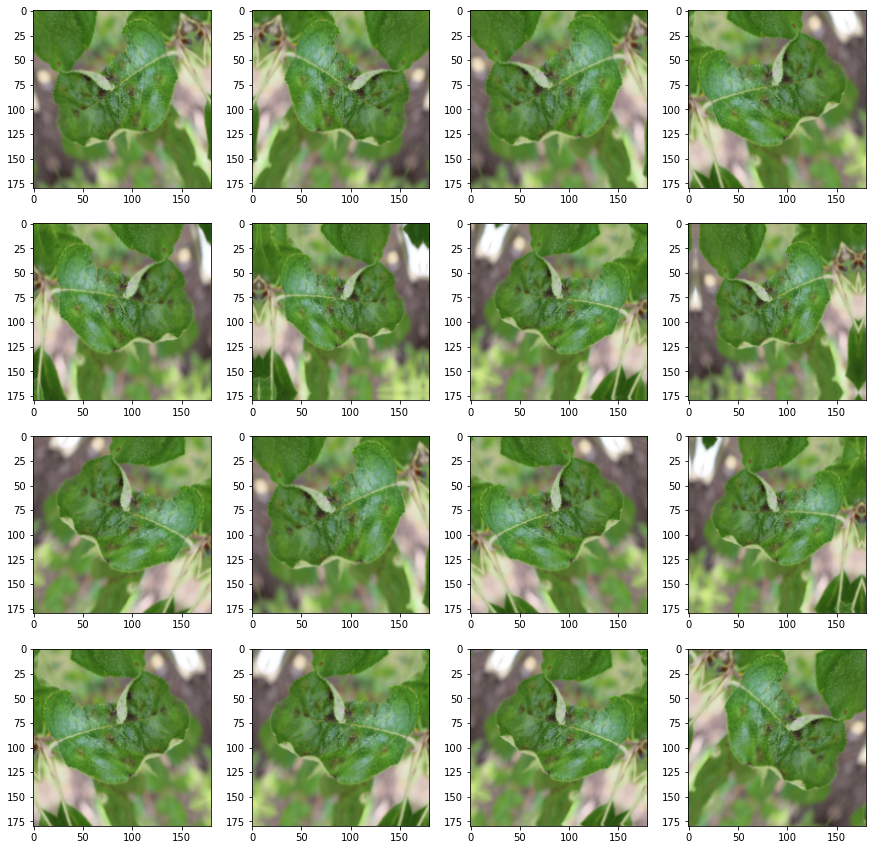

In [20]:
plt.figure(figsize=(15, 15))
for images, _ in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        

In [17]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate



model1 = Sequential()
model1.add(layers.Flatten(input_shape=(180, 180,3)))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(4,activation='softmax'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 97200)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               12441728  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 12,442,244
Trainable params: 12,442,244
Non-trainable params: 0
_________________________________________________________________


In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model1.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

The loss function can be used to compute the difference between the actual targets (as indicated by the training and/or testing data) and the targets generated by the model during an arbitrary epoch. The higher the difference, or the higher the loss, the worse the model performs. 

The goal of the machine learning training process is therefore to minimize loss.
Each machine learning scenario needs a different loss function. Since we deal with classification, we must use a function called cross entropy. It essentially compares the actual outcomes with the generated outcomes by computing the entropy, or the difficulty of successfully comparing between the classes. Since our data is categorical in nature, we use categorical crossentropy.

We use Adaptive Moment Estimation or Adam for optimization. It's one of the de facto standard optimizers that are used today.
For reasons of being more intuitive to humans, we also use accuracy as a metric.

In [17]:
epochs = 20

history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 5634.9736 - accuracy: 0.3191
Epoch 1: val_loss improved from inf to 30.24706, saving model to best.h5
46/46 [==============================] - 7s 131ms/step - loss: 5634.9736 - accuracy: 0.3191 - val_loss: 30.2471 - val_accuracy: 0.2885
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 11.0857 - accuracy: 0.2944
Epoch 2: val_loss improved from 30.24706 to 1.37770, saving model to best.h5
46/46 [==============================] - 5s 105ms/step - loss: 11.0857 - accuracy: 0.2944 - val_loss: 1.3777 - val_accuracy: 0.3214
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 1.3709 - accuracy: 0.3260
Epoch 3: val_loss improved from 1.37770 to 1.36694, saving model to best.h5
46/46 [==============================] - 4s 89ms/step - loss: 1.3709 - accuracy: 0.3260 - val_loss: 1.3669 - val_accuracy: 0.3214
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 1.3595 - accuracy: 0.32

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.25302812 0.21843414 0.26599914 0.26253864]]


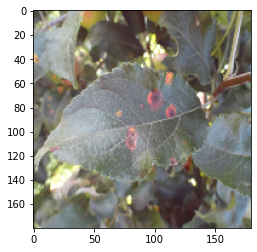

In [19]:
from keras_preprocessing import image
filepath = os.path.join(SOURCE, "Test_374" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model1.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.25302812 0.21843414 0.26599914 0.26253864]]


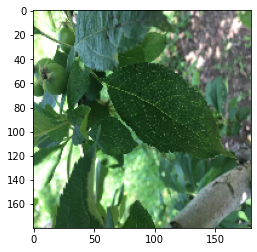

In [20]:

    

filepath = os.path.join(SOURCE, "Test_1800" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model1.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))





['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.25302812 0.21843414 0.26599914 0.26253864]]


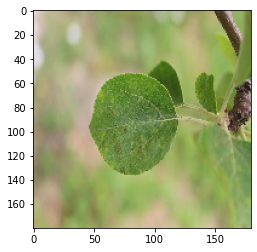

In [21]:
filepath = os.path.join(SOURCE, "Test_84" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model1.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))


['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.25302812 0.21843414 0.26599914 0.26253864]]


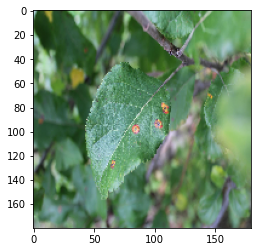

In [22]:
filepath = os.path.join(SOURCE, "Test_93" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model1.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))


In [23]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate


model2 = Sequential()
model2.add(data_augmentation)
model2.add(layers.Flatten(input_shape=(180, 180,3)))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(4,activation='softmax'))


In [24]:
model2.build(input_shape=(None,180, 180,3))
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 flatten_6 (Flatten)         (None, 97200)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               12441728  
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 4)                 516       
                                                                 
Total params: 12,442,244
Trainable params: 12,442,244
Non-trainable params: 0
_________________________________________________________________


In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_lost.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model2.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
epochs = 20

history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 6838.4429 - accuracy: 0.3226
Epoch 1: val_loss improved from inf to 1225.16919, saving model to best_lost.h5
46/46 [==============================] - 8s 164ms/step - loss: 6838.4429 - accuracy: 0.3226 - val_loss: 1225.1692 - val_accuracy: 0.2912
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 150.4104 - accuracy: 0.3548
Epoch 2: val_loss improved from 1225.16919 to 1.37837, saving model to best_lost.h5
46/46 [==============================] - 7s 152ms/step - loss: 150.4104 - accuracy: 0.3548 - val_loss: 1.3784 - val_accuracy: 0.3269
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 1.3713 - accuracy: 0.3452
Epoch 3: val_loss improved from 1.37837 to 1.36698, saving model to best_lost.h5
46/46 [==============================] - 7s 159ms/step - loss: 1.3713 - accuracy: 0.3452 - val_loss: 1.3670 - val_accuracy: 0.3269
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss:

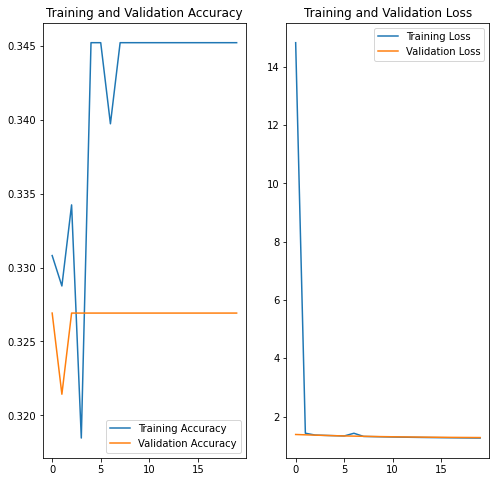

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
model3 = Sequential()
model3.add(data_augmentation)
model3.add( layers.Rescaling(1./255))
model3.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model3.add(layers.MaxPooling2D())
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(32, (3, 3),kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu'))
model3.add(layers.MaxPooling2D(pool_size=(2,2)))
model3.add(layers.BatchNormalization())
model3.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(5, 5)))
model3.add(layers.Dropout(0.4))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(num_classes, activation='softmax'))

In [31]:
model3.build(input_shape=(None,180, 180,3))
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 90, 90, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 88, 88, 32)      

We first define the model itself to be using the Sequential API, or, a stack of layers that together compose the **Convolutional Neural Network.**

Afterward, we did **data augmentation** to balance variance and bias. Next, we applied **normalization** to the data of the previous layer.

We start off with a two-dimensional convolutional layer, or a **Conv2D layer**. It learns **16 filters**, or feature maps, based on the data. The **kernel**, or the small image that slides over the larger one, is**3x3 pixels**. As expected, we use the **ReLU activation function for nonlinearity. **

The Conv2D layer is followed by a **MaxPooling2D layer** with a pool size of **2 x 2**. That is, we further summarize the derivation of the Conv2D layer by applying **max pooling with another image sliding** over the filters that is 2x2 pixels. For every slide, it takes the maximum value (hence max pooling) within the 2x2 box and passes it on. Hence, each 2x2 = 4 pixel wide slide is turned into a one-pixel output. This greatly reduces memory requirements while keeping mostly intact your model performance.

Finally, before repeating the convolutional layers, we add **Dropout**. Dropout, as said, essentially breaks the magnifiers we discussed at the start of this blog. Hence, **a little bit of random noise** is introduced during training. This greatly **reduces** the odds of **overfitting**. It does so by converting certain inputs to 0, and does so randomly. The parameter 0.40 is the dropout rate, or the number of input neurons to drop (in this case, 40% of the inputs is converted to 0).

Since we wish to summarize further, we repeat the Conv2D process (although learning more filters this time), the MaxPooling2D process and the Dropout process.

We must however convert the many filters learnt and processed to a flat structure before it can be processed by the part that can actually generate the predictions. Hence, we use the **Flatten layer**. Subsequently, we let the data pass through **two Dense layers**, of which the first is ReLU-activated and the second one is **Softmax-activated**. Softmax activation essentially **generates a multiclass probability distribution**, or computes the probability that the item belongs to one of the classes mulidisease,rust,scab,healty, summed to 1 (the maximum probability). 

Note that the number of output neurons is num_classes for the final layer for the same reason: since num_classes = 4 probabilities must be computed, we must have num_classes = 4 different outputs so that for every class a unique output exists.


**References:** https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-cnn-classifier-with-keras.md

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_lost.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model3.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
epochs = 20

history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 1.7107 - accuracy: 0.3741
Epoch 1: val_loss improved from inf to 1.32888, saving model to best.h5
46/46 [==============================] - 51s 1s/step - loss: 1.7107 - accuracy: 0.3741 - val_loss: 1.3289 - val_accuracy: 0.3407
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 1.1489 - accuracy: 0.4667
Epoch 2: val_loss did not improve from 1.32888
46/46 [==============================] - 45s 981ms/step - loss: 1.1489 - accuracy: 0.4667 - val_loss: 1.3301 - val_accuracy: 0.3709
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 1.0876 - accuracy: 0.5230
Epoch 3: val_loss improved from 1.32888 to 1.29613, saving model to best.h5
46/46 [==============================] - 50s 1s/step - loss: 1.0876 - accuracy: 0.5230 - val_loss: 1.2961 - val_accuracy: 0.3599
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.9573 - accuracy: 0.6198
Epoch 4: val_loss improved from 1.29613

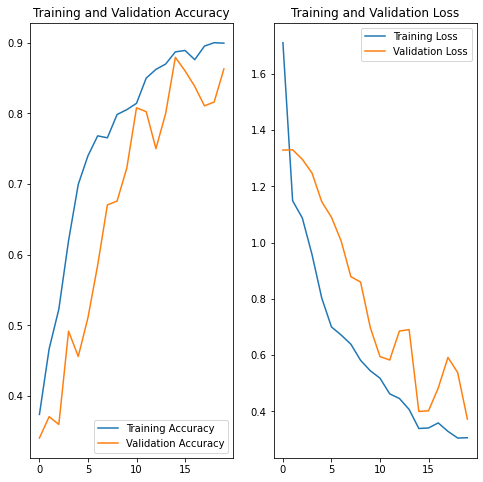

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
from keras_preprocessing import image

test_set = pd.read_csv("test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test)

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.45438915 0.18042848 0.18197352 0.18320887]]


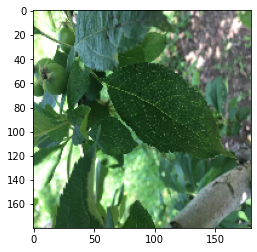

In [42]:

    

filepath = os.path.join(SOURCE, "Test_1800" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model3.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))





['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.18511812 0.17813566 0.17734869 0.45939758]]


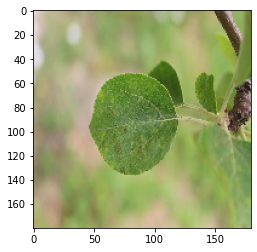

In [48]:
filepath = os.path.join(SOURCE, "Test_84" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model3.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))


['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17846006 0.19186306 0.45121676 0.17846006]]


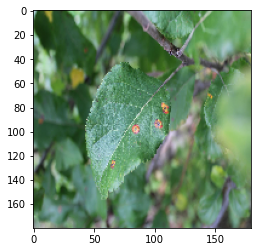

In [47]:
filepath = os.path.join(SOURCE, "Test_93" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model3.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))


['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17521204 0.17630488 0.47327584 0.1752072 ]]


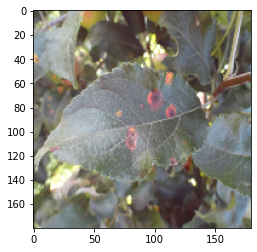

In [46]:
filepath = os.path.join(SOURCE, "Test_374" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model3.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

In [49]:
predictions = model3.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

healthy  multiple_diseases      rust      scab
image_id                                                 
Test_0    0.176271           0.181113  0.466345  0.176271
Test_1    0.183750           0.225504  0.406996  0.183750
Test_2    0.175794           0.177326  0.175524  0.471357
Test_3    0.418226           0.185680  0.208185  0.187909
Test_4    0.174926           0.175085  0.475064  0.174926

In [30]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
# input layer
visible = Input(shape=(180,180,3))
# first feature extractor
conv1 = Conv2D(64, kernel_size= 6, padding='same', activation='relu')(visible)
batch1 = (layers.BatchNormalization())(conv1)
pool1 = MaxPool2D(pool_size=(3, 3))(batch1)
conv2 = Conv2D(32, (3, 3),kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(pool1)
batch2 = (layers.BatchNormalization())(conv2)
pool2 = MaxPool2D(pool_size=(3, 3))(batch2)
conv3 = Conv2D(16, kernel_size= 6, padding='same', activation='relu')(pool2)
batch3 = (layers.BatchNormalization())(conv3)
pool3 = MaxPool2D(pool_size=(3, 3))(batch3)
flat1 = Flatten()(pool3)
# second feature extractor
cov1 = Conv2D(64, kernel_size= 8, padding='same', activation='relu')(visible)
bach1 = (layers.BatchNormalization())(cov1)
pol1 = MaxPool2D(pool_size=(4, 4))(bach1)
cov2 = Conv2D(32, (3, 3),kernel_initializer='glorot_uniform', bias_initializer='zeros', activation='relu')(pol1)
bach2 = (layers.BatchNormalization())(cov2)
pol2 = MaxPool2D(pool_size=(4, 4))(bach2)
cov3 = Conv2D(16, kernel_size= 6, padding='same', activation='relu')(pol2)
bach3 = (layers.BatchNormalization())(cov3)
pol3 = MaxPool2D(pool_size=(3, 3))(bach3)
flat2 = Flatten()(pol3)
# merge feature extractors
merge = concatenate([flat1, flat2])
# interpretation layer
hidden1 = Dense(64, activation='relu')(merge)
# prediction output
pool2 = (layers.Dropout(0.4))(batch2)
output = Dense(4, activation='softmax')(hidden1)
model4 = Model(inputs=visible, outputs=output)
# summarize layers
print(model4.summary())



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 180, 180, 64  6976        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_14 (Conv2D)             (None, 180, 180, 64  12352       ['input_8[0][0]']                
                                )                                                           

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_lost.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model4.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
epochs = 20

history = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 1.4726 - accuracy: 0.4125
Epoch 1: val_loss improved from inf to 6.22692, saving model to best_lost.h5
46/46 [==============================] - 179s 4s/step - loss: 1.4726 - accuracy: 0.4125 - val_loss: 6.2269 - val_accuracy: 0.3269
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 1.0091 - accuracy: 0.5806
Epoch 2: val_loss improved from 6.22692 to 3.59829, saving model to best_lost.h5
46/46 [==============================] - 177s 4s/step - loss: 1.0091 - accuracy: 0.5806 - val_loss: 3.5983 - val_accuracy: 0.2912
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.8755 - accuracy: 0.6513
Epoch 3: val_loss improved from 3.59829 to 1.61276, saving model to best_lost.h5
46/46 [==============================] - 177s 4s/step - loss: 0.8755 - accuracy: 0.6513 - val_loss: 1.6128 - val_accuracy: 0.3791
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.

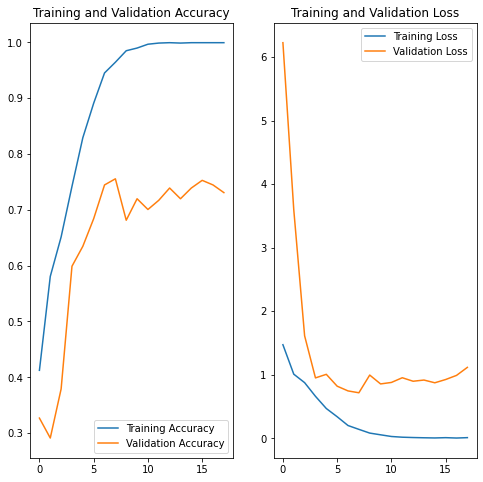

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
from keras_preprocessing import image

test_set = pd.read_csv("test.csv", index_col=0)

X_test = []
for index, data in test_set.iterrows():
    filepath = os.path.join(SOURCE, index + ".jpg")
    img = image.load_img(filepath, target_size=(img_height, img_width))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    X_test.append(x)
    
X_test = np.vstack(X_test)

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17488588 0.17490752 0.47532123 0.1748853 ]]


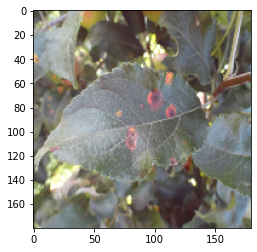

In [37]:
filepath = os.path.join(SOURCE, "Test_374" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model4.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17487924 0.1748838  0.47535777 0.17487913]]


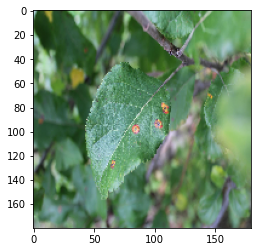

In [36]:
filepath = os.path.join(SOURCE, "Test_93" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model4.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))


In [38]:
predictions = model4.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

healthy  multiple_diseases      rust      scab
image_id                                                 
Test_0    0.175156           0.175577  0.474184  0.175083
Test_1    0.183685           0.181771  0.426392  0.208152
Test_2    0.177900           0.175585  0.175590  0.470925
Test_3    0.475332           0.174883  0.174884  0.174901
Test_4    0.174879           0.174882  0.475360  0.174879

**DenseNet**

Densely Connected Convolutional Networks (DenseNets), are a popular CNN-based ImageNet used for a variety of applications, inclusing classification, segmentation, localization, etc. Most models before DenseNet relied solely on network depth for representational power. Instead of drawing representational power from extremely deep or wide architectures, DenseNets exploit the potential of the network through feature reuse. This was the main motivation behind the DenseNet architecture. Now let us train DenseNet on leaf images and evaluate its performance.


In [161]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="densenet.png", width=1000, height=750)

In [75]:
from tensorflow.keras.applications import DenseNet169
model = tf.keras.Sequential([data_augmentation,
          layers.Rescaling(1./255),
                             DenseNet169(input_shape=(180, 180, 3),
                                             weights='imagenet',
                                             include_top=False),
                                 layers.GlobalAveragePooling2D(),
                                 layers.BatchNormalization(),
                                 layers.Dense(64, activation='relu'),
                                 layers.Dropout(0.4),
                                 layers.Dense(4,
                                         activation='softmax')])
        
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_lost.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [76]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 batch_normalization_13 (Bat  (None, 180, 180, 3)      12        
 chNormalization)                                                
                                                                 
 densenet169 (Functional)    (None, 5, 5, 1664)        12642880  
                                                                 
 global_average_pooling2d_6   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)               

In [77]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.7557 
Epoch 1: val_loss improved from inf to 4.23709, saving model to best.h5
46/46 [==============================] - 685s 15s/step - loss: 0.7356 - accuracy: 0.7557 - val_loss: 4.2371 - val_accuracy: 0.4890
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.8682 
Epoch 2: val_loss did not improve from 4.23709
46/46 [==============================] - 680s 15s/step - loss: 0.4461 - accuracy: 0.8682 - val_loss: 10.9517 - val_accuracy: 0.4038
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.8977 
Epoch 3: val_loss improved from 4.23709 to 1.40288, saving model to best.h5
46/46 [==============================] - 667s 15s/step - loss: 0.3687 - accuracy: 0.8977 - val_loss: 1.4029 - val_accuracy: 0.7610
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.8977 
Epoch 4: val_loss improved from

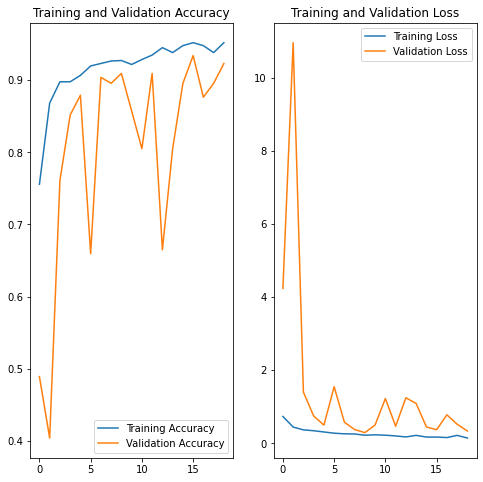

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.47536692 0.17487772 0.17487772 0.17487772]]


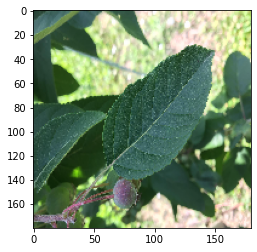

In [79]:

filepath = os.path.join(SOURCE, "Test_979" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))



['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17487963 0.1748837  0.1748792  0.4753575 ]]


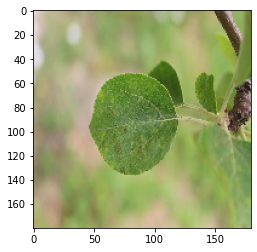

In [80]:
filepath = os.path.join(SOURCE, "Test_84" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17498204 0.17532623 0.4747105  0.17498128]]


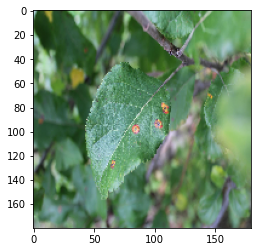

In [81]:

filepath = os.path.join(SOURCE, "Test_93" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17517419 0.17530543 0.47450495 0.17501542]]


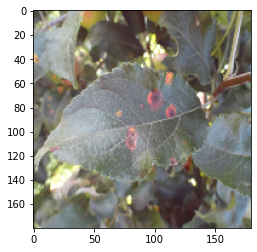

In [82]:
filepath = os.path.join(SOURCE, "Test_374" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

In [83]:
predictions = model.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

healthy  multiple_diseases      rust      scab
image_id                                                 
Test_0    0.174910           0.175017  0.475162  0.174910
Test_1    0.174961           0.175055  0.475057  0.174927
Test_2    0.174883           0.174901  0.174883  0.475333
Test_3    0.475367           0.174878  0.174878  0.174878
Test_4    0.187405           0.261558  0.363666  0.187371

**EfficientNet** 
EfficientNet is another popular (more recent) CNN-based ImageNet model which achieved the SOTA on several image-based tasks in 2019. EfficientNet performs model scaling in an innovative way to achieve excellent accuracy with significantly fewer parameters. It achieves the same if not greater accuracy than ResNet and DenseNet with a mcuh shallower architecture. Now let us train EfficientNet on leaf images and evaluate its performance.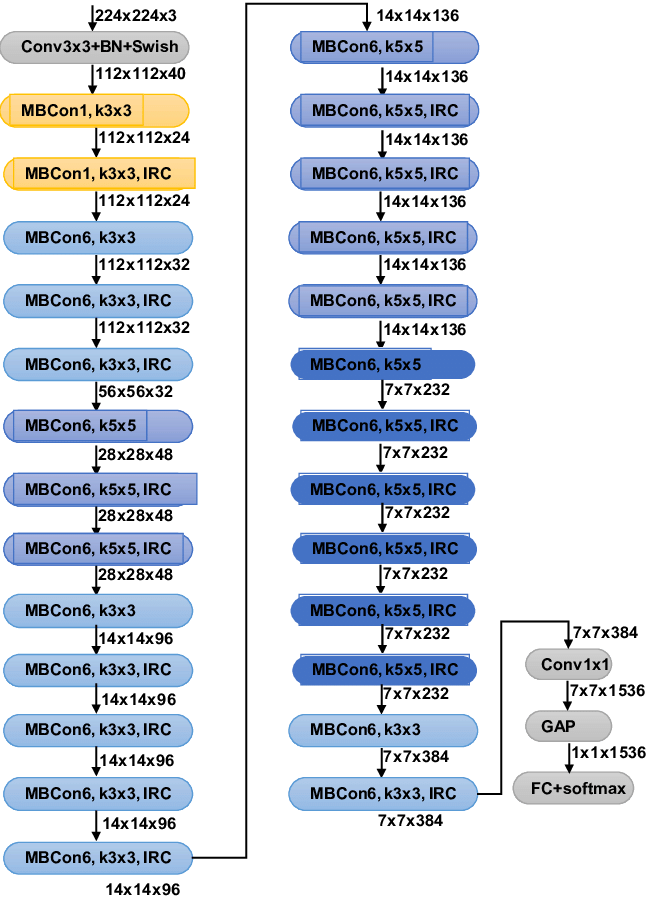


In [85]:
import efficientnet.tfkeras as efn
model = tf.keras.Sequential([data_augmentation,
      layers.Rescaling(1./255),
                             efn.EfficientNetB3(input_shape=(180, 180, 3),
                                                    weights='imagenet',
                                                    include_top=False),
                                 L.GlobalAveragePooling2D(),
                                 layers.BatchNormalization(),
                                 L.Dense(4,
                                         activation='softmax')])
    
    
        
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  monitor="val_loss",
                                                  verbose=2,
                                                  mode="auto")
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", 
                                                monitor="val_loss",
                                                mode="auto",
                                                verbose=2,
                                                save_best_only=True)
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 batch_normalization_14 (Bat  (None, 180, 180, 3)      12        
 chNormalization)                                                
                                                                 
 efficientnet-b3 (Functional  (None, 6, 6, 1536)       10783528  
 )                                                               
                                                                 
 global_average_pooling2d_7   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                     

In [86]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.7852 
Epoch 1: val_loss improved from inf to 1.28958, saving model to best.h5
46/46 [==============================] - 516s 11s/step - loss: 0.6485 - accuracy: 0.7852 - val_loss: 1.2896 - val_accuracy: 0.8132
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.8964 
Epoch 2: val_loss improved from 1.28958 to 0.87592, saving model to best.h5
46/46 [==============================] - 495s 11s/step - loss: 0.3231 - accuracy: 0.8964 - val_loss: 0.8759 - val_accuracy: 0.8681
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.2558 - accuracy: 0.9307 
Epoch 3: val_loss improved from 0.87592 to 0.55783, saving model to best.h5
46/46 [==============================] - 505s 11s/step - loss: 0.2558 - accuracy: 0.9307 - val_loss: 0.5578 - val_accuracy: 0.8846
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9279 
Epo

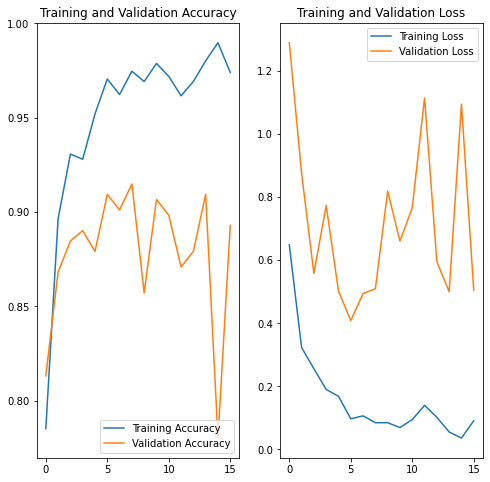

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = len(acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.45951962 0.17743547 0.1772892  0.18575567]]


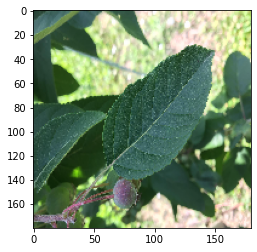

In [88]:

filepath = filepath = os.path.join(SOURCE, "Test_979" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))


['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.4610554  0.17705862 0.17705782 0.1848282 ]]


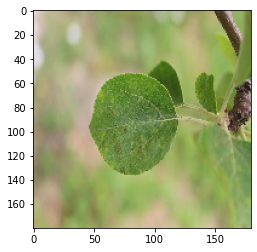

In [89]:
filepath = filepath = os.path.join(SOURCE, "Test_84" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.17489612 0.17490949 0.47530594 0.17488848]]


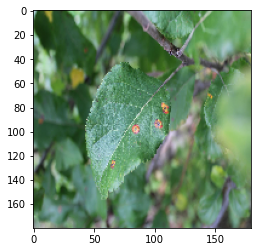

In [90]:

filepath = filepath = os.path.join(SOURCE, "Test_93" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))


['healthy', 'multiple_diseases', 'rust', 'scab']
[[0.18432444 0.1846861  0.4296908  0.20129868]]


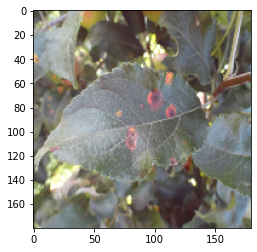

In [91]:
filepath = filepath = os.path.join(SOURCE, "Test_374" + ".jpg")
img = image.load_img(filepath, target_size=(img_height, img_width))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
predict = model.predict(x)
score = tf.nn.softmax(predict)
print(class_names)
print(np.array(score))

In [157]:
predictions = model.predict(X_test, batch_size= 10)
score = tf.nn.softmax(predictions)
score = np.array(score)
df_out = pd.concat([test_set.reset_index(), pd.DataFrame(score, columns = class_names)], axis=1).set_index("image_id")
df_out.to_csv('submission.csv')
df_out.head()

healthy  multiple_diseases      rust      scab
image_id                                                 
Test_0    0.174878           0.174878  0.475367  0.174878
Test_1    0.174878           0.174878  0.475366  0.174878
Test_2    0.201818           0.180721  0.181594  0.435867
Test_3    0.475366           0.174878  0.174878  0.174878
Test_4    0.174879           0.174881  0.475361  0.174879

| Models   | Training Accuracy   | Validation Accuracy   | Training Time  | Test Accuracy |
| --- | --- | --- | --- | --- |
| Model Simple | 0.34  | 0.32       | 220 second   |0.500|
| Model I created | 0.89  | 0.86    | 1000 second   |0.913|
| DenseNet 169 | 0.95  | 0.92   | 12350 second  |0.935|
| EfficientNet B3 | 0.97  | 0.89   | 8000 second   |0.941|

# Summary

- Images include mislabeled images. There is no way to fix this unfortunately but to reduce the damage of this, other images can be sparse by duplicating the correct ones with data augmented. For this, methods such as zoom, flipping, and rotating can be used.

- Some models are high in bias, and some are high in variance. These can be seen thanks to the error values obtained. In the Efficientnet B3 model, the variance value is higher than the others. Batch normalization and data augmentation can be applied to prevent this a little bit. In addition, dropout is also a suitable method for this.

- The values get better according to the multiplicity of the epoch number. The excess of the parameter also keeps the bias value on the average. If we don't want the bias value to get too high anyway, it might make sense to either change the algorithm or add more layers. The man algorithm for optimization is preferred for all. In addition, early stopping was also considered. The best model was EfficientNet B3 according to the latest situation. It is better than all in terms of both error and accuracy. Kaggle got the best result of 0.941 (test set result) in the competition results.